In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
import ants
import matplotlib.pyplot as plt

from src.ants_padding import AntsPadding
from src.improved_padding import ImprovedPadding
from src.utils import get_mask, compute_js_divergence, compute_kl_divergence
from tqdm.auto import tqdm


In [9]:
dir_hard_drive = Path("/media/maichi/T7")
list_patients = (dir_hard_drive / "list_patients.txt").read_text().split("\n")
list_patients = [list_patients[i] for i in np.argsort([int(patient.strip("AIDREAM_")) for patient in list_patients if patient.startswith("AIDREAM_")])]
print("Nbr of patients: ", len(list_patients))

list_cercare = ["brainmask", "CTH"]


Nbr of patients:  186


In [10]:
DICT_CERCARE_P = {
    "COV": 2, "CTH": 2, "Delay": 2, "rCBV": 2,
    "rLeakage": 1, "OEF": 3, "rCMRO2": 2
}


In [11]:
def get_biomarker(patient: str, biomarker: str):

    assert biomarker in DICT_CERCARE_P.keys(), f"Unknown biomarker: {biomarker} !"

    path_biomarker = dir_hard_drive / "PERFUSION_DATA/NIFTI" / patient / "pre_RT" / "CERCARE" / f"{patient}_pre_RT_{biomarker}.nii.gz"
    assert path_biomarker.exists(), f"Missing {biomarker} for {patient} !"

    return ants.image_read(str(path_biomarker))


In [12]:
def get_histogram(image: ants.ANTsImage, p, bins = None) -> np.ndarray:

    mask_image = get_mask(image.numpy())
    image_values = image[mask_image == 1].flatten()
    image_values = np.round(image_values, p)

    if bins is None:
        bin_width = 10**-p
        min_val = np.floor(np.min(image_values) / bin_width) * bin_width
        max_val = np.ceil(np.max(image_values) / bin_width) * bin_width
        bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Compute the histogram :
    hist_image, bins_image = np.histogram(image_values, bins=bins, density=True)

    return hist_image, bins_image


In [13]:
# Determine the min and max values for the all the biomarkers :

df_minmax = pd.DataFrame(columns=["patient", "biomarker", "min", "max"])

for patient in tqdm(list_patients):

    for biomarker in DICT_CERCARE_P.keys():

        image = get_biomarker(patient, biomarker)

        df_minmax.loc[len(df_minmax)] = [patient, biomarker, image.min(), image.max()]



  0%|          | 0/186 [00:00<?, ?it/s]

In [15]:
df_cth = df_minmax[df_minmax["biomarker"] == "CTH"]

array([[<Axes: title={'center': 'min'}>, <Axes: title={'center': 'max'}>]],
      dtype=object)

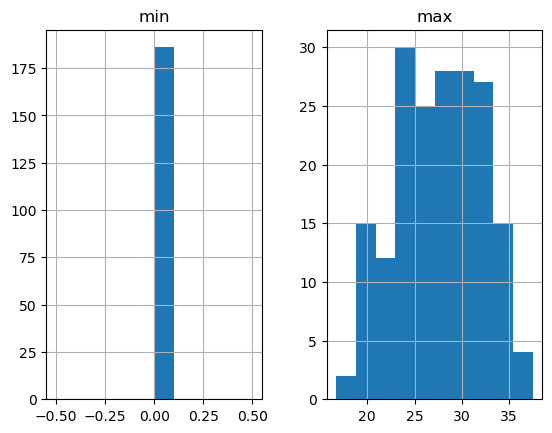

In [19]:
df_cth.hist()

<Axes: >

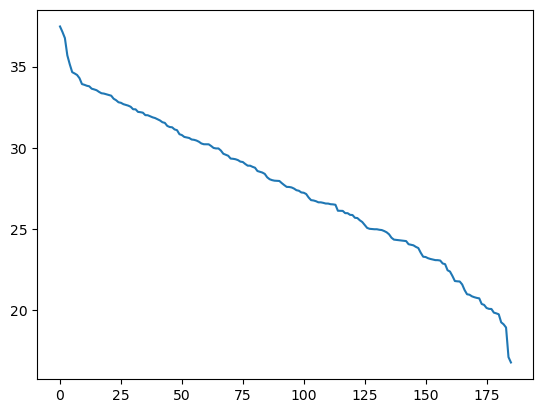

In [23]:
df_cth["max"].sort_values(ascending=False).reset_index(drop=True).plot()